In [17]:
import pandas as pd
import datetime
import gc
from sklearn.ensemble import (
BaggingRegressor, RandomForestRegressor, AdaBoostRegressor)
from sklearn.metrics import mean_squared_error
from technical_indicators import * # import all function
from sklearn.model_selection import TimeSeriesSplit
#import parfit as pf
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn import linear_model

In [18]:
# read in our data
url = "https://raw.githubusercontent.com/meenmo/Stat479_Project/master/Data/IBM.csv"
df_ORIGINAL = pd.read_csv(url)
df_ORIGINAL.drop(['Close'], axis = 1, inplace = True)
df_ORIGINAL.columns = ['Date', 'High', 'Low', 'Open', 'Volume', 'Close']
#df_ORIGINAL = pd.read_csv('IBM.csv')

In [19]:
df_features = df_ORIGINAL
df_features['Date'] = pd.to_datetime(df_features['Date'])
df_features.head()

,Date,High,Low,Open,Volume,Close
0,2002-01-02,121.500000,119.800003,120.599999,6862800,84.677422
1,2002-01-03,124.220001,120.250000,121.500000,8621700,86.182800
2,2002-01-04,125.599999,123.980003,124.050003,8405200,87.534859
3,2002-01-07,126.190002,123.699997,125.000000,5939600,86.454575
4,2002-01-08,125.199997,123.730003,124.250000,5311800,86.907600


In [20]:
### Create Lag Features
# this is exactly what the book does for create_lag_features from chapter 29
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 2):
        df_lag = df_ret[['Date', 'Close']].copy()
        # generate dataframe to shift index by i day.
        df_lag['Date'] = df_lag['Date'].shift(-i)
        df_lag.columns = ['Date', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['Date'], right_on = ['Date'])
    
    #frees memory
    del df_lag
    
    # calculate today's percentage lag
    df_ret['Today'] = (df_ret['Close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
    # calculate percentage lag
    for i in range(1, lag_days + 1):
        df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
    # drop unneeded columns which are value_lags
    for i in range(1, lag_days + 2):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret

In [21]:
df_features = create_lag_features(df_features, 5) # 5 lag features
df_features.head()

,Date,High,Low,Open,Volume,Close,Today,lag1,lag2,lag3,lag4,lag5
0,2002-01-02,121.500000,119.800003,120.599999,6862800,84.677422,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-01-03,124.220001,120.250000,121.500000,8621700,86.182800,1.777781,NaN,NaN,NaN,NaN,NaN
2,2002-01-04,125.599999,123.980003,124.050003,8405200,87.534859,1.568826,1.777781,NaN,NaN,NaN,NaN
3,2002-01-07,126.190002,123.699997,125.000000,5939600,86.454575,-1.234119,1.568826,1.777781,NaN,NaN,NaN
4,2002-01-08,125.199997,123.730003,124.250000,5311800,86.907600,0.524004,-1.234119,1.568826,1.777781,NaN,NaN


In [22]:
# drop earlier data with missing lag features
df_features.dropna(inplace=True)

In [23]:
# reset index
df_features.reset_index(drop = True, inplace = True)

#### GENERATE TECHNICAL INDICATORS FEATURES
df_features = standard_deviation(df_features, 14)

df_features = relative_strength_index(df_features, 14) # periods
df_features = average_directional_movement_index(df_features, 14, 13) # n, n_ADX
df_features = moving_average(df_features, 21) # periods
df_features = exponential_moving_average(df_features, 21) # periods
df_features = momentum(df_features, 14) # 

df_features = average_true_range(df_features, 14)
df_features = bollinger_bands(df_features, 21)
df_features = ppsr(df_features)
df_features = stochastic_oscillator_k(df_features)
df_features = stochastic_oscillator_d(df_features, 14)
df_features = trix(df_features, 14)
df_features = macd(df_features, 26, 12)
df_features = mass_index(df_features)
df_features = vortex_indicator(df_features, 14)

df_features = kst_oscillator(df_features, 10, 10, 10, 15, 10, 15, 20, 30)
df_features = true_strength_index(df_features, 25, 13)

#df_features = accumulation_distribution(df_features, 14) # Causes Problems, apparently
df_features = chaikin_oscillator(df_features)
df_features = money_flow_index(df_features, 14)
df_features = on_balance_volume(df_features, 14)
df_features = force_index(df_features, 14)
df_features = ease_of_movement(df_features, 14)
df_features = commodity_channel_index(df_features, 14)
df_features = keltner_channel(df_features, 14)
df_features = ultimate_oscillator(df_features)
df_features = donchian_channel(df_features, 14)
    
# drop earlier data with missing lag features
df_features.dropna(inplace=True)
df_features = df_features.reset_index(drop = True)

In [24]:
display(df_features.head())

,Date,High,Low,Open,Volume,Close,Today,lag1,lag2,lag3,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
0,2002-03-14,107.949997,106.589996,107.019997,5335500,74.391068,-0.541176,-1.216580,3.097695,0.142742,...,0.714286,1.962464e+06,-2.921157e+07,2.286739e-07,0.959960,93.032764,95.832764,90.232765,0.034641,13.389999
1,2002-03-15,107.449997,105.589996,106.550003,10864100,74.523666,0.178246,-0.541176,-1.216580,3.097695,...,0.642857,3.445814e+06,5.695471e+06,2.086708e-07,0.713277,93.570735,96.351449,90.790020,0.031385,13.389999
2,2002-03-18,108.639999,106.230003,107.099999,5301200,74.216637,-0.411990,0.178246,-0.541176,-1.216580,...,0.714286,3.898193e+06,-4.066156e+07,2.500726e-07,0.779588,94.192408,96.916693,91.468123,0.058735,13.389999
3,2002-03-19,108.050003,106.489998,106.849999,4614800,75.012154,1.071885,-0.411990,0.178246,-0.541176,...,0.714286,3.372200e+06,-4.964177e+07,2.263920e-07,0.762796,94.770295,97.348152,92.192438,0.057835,13.389999
4,2002-03-20,106.900001,105.489998,106.900001,4844100,73.623466,-1.851283,1.071885,-0.411990,0.178246,...,0.642857,2.459121e+06,-1.593928e+07,2.007584e-07,0.060704,95.249347,97.800775,92.697918,0.026201,13.389999


In [26]:
# do time series split DOING NUMBER 2
splits = TimeSeriesSplit(n_splits=5)

# stores all labels
y = df_features['Today']

# drop unneded columns
df_features.drop(['Open','Close','Low','High','Today'], axis = 1, inplace = True)

# all training data
X_train_all = df_features.loc[(df_features['Date'] < '2018-01-01')]
y_train_all = y[X_train_all.index]

# creates all test data which is all after January 2018
X_test = df_features.loc[(df_features['Date'] >= '2018-01-01'),:]
y_test = y[X_test.index]

In [27]:
trainsamples = []
model1metrics = []
model2metrics = []
model3metrics = []
model4metrics = []

for train_index, test_index in splits.split(X_train_all.loc[:,'Date']):
    
    # do the split for train, Take row 0 to last element of train index
    X_train = X_train_all.loc[0:train_index[len(train_index) - 1],:]
    y_train = y[X_train.index]
        
    # do the split for validation, Take first element of test index to last element of test index
    X_val = X_train_all.loc[test_index[0]:test_index[len(test_index) - 1],:]
    y_val = y[X_val.index]
        
    # print some useful info
    print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
    print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
    print('Training Observations: ', (X_train.shape[0]))
    print('Testing Observations: ', (X_test.shape[0]))
    
    # drop date
    X_train.drop(['Date'], axis = 1, inplace = True)
    X_val.drop(['Date'], axis = 1, inplace = True)
    
    trainsamples.append(X_train.shape[0])
    
    # random forest regression based on default parameter
    rf = RandomForestRegressor(random_state = 0)
    rf.fit(X_train, y_train)
    model1metrics.append([mean_squared_error(y_val, rf.predict(X_val)),r2_score(y_val, rf.predict(X_val))])
    
    # bagging based on default parameter
    bag = BaggingRegressor(DecisionTreeRegressor())
    bag.fit(X_train, y_train)
    model2metrics.append([mean_squared_error(y_val, bag.predict(X_val)),r2_score(y_val, bag.predict(X_val))])
    
    # boosting on default parameter
    boost = AdaBoostRegressor(DecisionTreeRegressor(), random_state = 0, learning_rate=0.01)
    boost.fit(X_train, y_train)
    model3metrics.append([mean_squared_error(y_val, boost.predict(X_val)),r2_score(y_val, boost.predict(X_val))])
    
    # linear regression on default parameter
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    model4metrics.append([mean_squared_error(y_val, lr.predict(X_val)),r2_score(y_val, lr.predict(X_val))])

Observations:  875
Cutoff date, or first date in validation data:  2004-11-01 00:00:00
Training Observations:  664
Testing Observations:  211


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Observations:  1538
Cutoff date, or first date in validation data:  2007-06-21 00:00:00
Training Observations:  1327
Testing Observations:  211


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Observations:  2201
Cutoff date, or first date in validation data:  2010-02-08 00:00:00
Training Observations:  1990
Testing Observations:  211


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Observations:  2864
Cutoff date, or first date in validation data:  2012-09-24 00:00:00
Training Observations:  2653
Testing Observations:  211


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Observations:  3527
Cutoff date, or first date in validation data:  2015-05-15 00:00:00
Training Observations:  3316
Testing Observations:  211


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


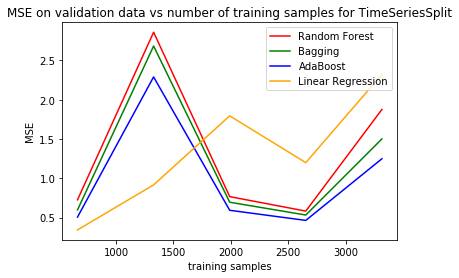

In [28]:
plt.plot(trainsamples,[item[0] for item in model1metrics], color = 'r', label = 'Random Forest')
plt.plot(trainsamples,[item[0] for item in model2metrics], color = 'g', label = 'Bagging')
plt.plot(trainsamples,[item[0] for item in model3metrics], color = 'b', label = 'AdaBoost')
plt.plot(trainsamples,[item[0] for item in model4metrics], color = 'orange', label = 'Linear Regression')

plt.title('MSE on validation data vs number of training samples for TimeSeriesSplit')
plt.xlabel('training samples')
plt.ylabel('MSE')
plt.legend()

#plt.rcParams['figure.figsize'] = [15,10]

plt.show()

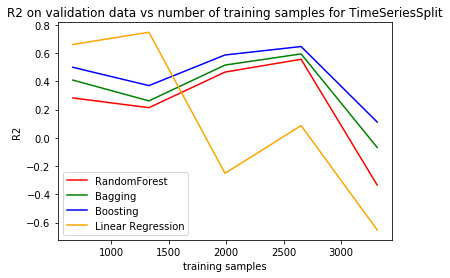

In [29]:
plt.plot(trainsamples,[item[1] for item in model1metrics], color = 'r', label = 'RandomForest')
plt.plot(trainsamples,[item[1] for item in model2metrics], color = 'g', label = 'Bagging')
plt.plot(trainsamples,[item[1] for item in model3metrics], color = 'b', label = 'Boosting')
plt.plot(trainsamples,[item[1] for item in model4metrics], color = 'orange', label = 'Linear Regression')

plt.title('R2 on validation data vs number of training samples for TimeSeriesSplit')
plt.xlabel('training samples')
plt.ylabel('R2')
plt.legend()

plt.rcParams['figure.figsize'] = [15,10]

plt.show()

## Hyperparameter Tuning on last validation fold

In [ ]:
rf = RandomForestRegressor(random_state = 0)

# hyperparameter tuning on randomforest
paramGrid = ParameterGrid({
    'n_estimators': [10,15,20],
    'max_depth' : [10,15],
    'min_samples_leaf': [3,5,10]})
    
best_model, best_score, all_models, all_scores = pf.bestFit(rf, paramGrid, X_train, y_train, X_val, y_val, metric=mean_squared_error, greater_is_better=False, scoreLabel='MSE')
    
print(best_model)

In [ ]:
bag = BaggingRegressor(DecisionTreeRegressor(), random_state = 0)

# hyperparameter tuning on bagging
paramGrid = ParameterGrid({
    'max_features': [10,15,20],
    'n_estimators' : [5,10,15,20],
    })
    
best_model, best_score, all_models, all_scores = pf.bestFit(bag, paramGrid, X_train, y_train, X_val, y_val, metric=mean_squared_error, greater_is_better=False, scoreLabel='MSE')
    
print(best_model)

In [ ]:
boost = AdaBoostRegressor(DecisionTreeRegressor(), random_state = 0)

# hyperparameter tuning on Boosting
paramGrid = ParameterGrid({
    'learning_rate': [0.1,0.01],
    'n_estimators' : [5,10,15,20],
    })
    
best_model, best_score, all_models, all_scores = pf.bestFit(boost, paramGrid, X_train, y_train, X_val, y_val, metric=mean_squared_error, greater_is_better=False, scoreLabel='MSE')
    
print(best_model)

In [ ]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

bag = BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=20,
         max_samples=1.0, n_estimators=20, n_jobs=1, oob_score=False,
         random_state=0, verbose=0, warm_start=False)

boost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=0.01, loss='linear', n_estimators=15,
         random_state=0)

lr = linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

rf.fit(X_train, y_train)
bag.fit(X_train, y_train)
boost.fit(X_train, y_train)
lr.fit(X_train, y_train)

In [ ]:
# mse and r2 on validation fold
print('mse level2: ', mean_squared_error(y_val, lr.predict(X_val)))
print('r2_score: ' , r2_score(y_val, lr.predict(X_val)))

In [ ]:
# Linear Regression is the best model
X_test.drop(['Date'], axis = 1, inplace = True)
y_pred = lr.predict(X_test)

In [ ]:
# mse and r2 on test fold
print('mse level2: ', mean_squared_error(y_test, y_pred))
print('r2_score: ' , r2_score(y_test, y_pred))

In [ ]:
plt.plot(y_test.index, y_pred)
plt.plot(y_test.index, y_test)

plt.xlabel('index')
plt.ylabel('% return')
plt.title('% return on test dataset')
plt.show()